## Instructions

1. Do not write your name on the assignment. Be careful about any warnings that might display some file path with your name included.

2. You may talk to a friend, discuss the questions and potential directions for solving them. However, you need to write your own solutions and code separately, and not as a group activity.

3. Write your code in the *Code* cells and print the instructed output. If you are instructed to explain something in words, write your answer in the *Markdown* cells of the Jupyter notebook. Ensure that the solution is coded and/or written neatly enough to understand and grade.

4. Use [Quarto](https://quarto.org/docs/output-formats/html-basics.html) to render the *.ipynb* file as HTML. You will need to open the command prompt, navigate to the directory containing the file, and use the command: `quarto render filename.ipynb --to html`. Submit the HTML file.

5. This assignment is worth 100 points and is due on **February 17, 2025 at 11:59 pm**. 

6. **Five points given for properly formatting the assignment**. The breakdown is as follows:
- The submission must be an HTML file rendered using Quarto. (2 points).
- There are not excessively long outputs of extraneous information. (e.g. no printouts of entire data frames without good reason; there are not long printouts of which iteration a loop is on; there are not long sections of commented-out code, etc.) (1 point)
- Final answers for each question are written in Markdown cells. (1 point).
- There is no piece of unnecessary / redundant code, and no unnecessary / redundant text. (1 point)

## Introduction (0 points)

Read the data from **train.csv**, **test1.csv**, and **test2.csv**. All three datasets are about direct marketing campaigns for a Portuguese banking institution. The marketing campaigns were based on phone calls, where bank clients were called to subscribe for a term deposit. Each observation is a phone call and the variables are as follows:

1. `age`: Age of the client

2. `education`: Education level of the client 

3. `day`: Day of the month the call is made

4. `month`: Month of the call 

5. `y`: Whether the client subscribed to a term deposit or not (This is the classification response.)

6. `duration`: Call duration, in seconds. This variable highly affects the output (e.g., if duration=0 then y='no'). Yet, the `duration` is not known before a call is performed. Also, after the end of the call, `y` is usually known. Therefore, it is a better idea to use this variable only for inference purposes and discard it if the intention is to have a realistic predictive model.

You will use these three datasets throughout this assignment. The data from **train.csv** will be the training dataset and the data from **test1.csv** and **test2.csv** will be the two test datasets.

(Source: [UCI Data Archive](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Please use the given datasets for the assignment, not the raw data from the source. It is just for reference.)

## 1) Investigating the Effect of Call Duration on Subscription Probability (41 points)

### a)

First of all, you need a numeric response variable for your statsmodels function. (Numeric, not Boolean!) Convert the response variable, `y`, of all three datasets into 0s for 'no' and 1s for 'yes'. **(2 points)**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder

from sklearn.metrics import accuracy_score, recall_score, precision_score,confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve

In [9]:
train = pd.read_csv('train.csv')
test1 = pd.read_csv('test1.csv')
test2 = pd.read_csv('test2.csv')

test1['y'] = test1['y'].map({'no':0, 'yes':1})
test2['y'] = test2['y'].map({'no':0, 'yes':1})
train['y'] = train['y'].map({'no':0, 'yes':1})

### b)

Using the training data and the **statsmodels** library, create and train a logistic regression model that predicts whether the client subscribed to a term deposit or not by using the call `duration` as the only predictor. Print the model summary. **(2 points)**

You will use this model to answer all the remaining parts of this question.

In [11]:
trained_model = smf.logit(formula='y~duration', data=train).fit()
trained_model.summary()

Optimization terminated successfully.
         Current function value: 0.305028
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                35000
Model:                          Logit   Df Residuals:                    34998
Method:                           MLE   Df Model:                            1
Date:                Mon, 17 Feb 2025   Pseudo R-squ.:                  0.1560
Time:                        22:06:04   Log-Likelihood:                -10676.
converged:                       True   LL-Null:                       -12650.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.1841      0.030   -107.465      0.000      -3.242      -3.126
duration       0.0035   6.24e-05     56.446      0.000       0.003       0.004
==============================================================================
"""

### c)

Is the effect of the call duration on the probability of client subscription statistically significant? **You need to justify your answer for credit.** **(2 points)**

The effect of call duration on subscription is statistically significant because the p-value is < 0.05.

### d)

What is the probability of the client subscribing after a 5-minute marketing call? (Note that `duration` is in seconds.) **(3 points)**

In [15]:
trained_model.predict(pd.DataFrame({'duration':[300]}))

0    0.106491
dtype: float64

The probability of a client subscribing after a 5-minute call is about 10%.

### e)

How many **minutes** are necessary in a marketing call to have at least 95% probability of the client subscribing? **(4 points)**

In [18]:
# log(0.95/1-.95) = trained_model.params['Intercept'] + trained_model.params['duration']*duration
((np.log(0.95/0.05) - trained_model.params['Intercept'])/trained_model.params['duration'])/60

28.989940038597858

29 minutes are necessary in a marketing call to have at least 95% probability of the client subscription.

### f)

What is the percentage increase in the odds of the client subscribing when the call duration increases by a **minute**? **(4 points)**

In [21]:
per_min = (np.exp(60*trained_model.params['duration']) - 1)*100
print(f'Percentage increase in odds of subscription per minute duration:    {per_min}%')


Percentage increase in odds of subscription per minute duration:    23.540942175386583%


### g)

How many **minutes** need to be added to the duration of a marketing call to double the odds of the client subscribing? **(3 points)**

In [23]:
print(np.log(2)/trained_model.params['duration']/60)

print(f'About 3 min 18 sec')

3.278804213193095
About 3 min 18 sec


### h)

After exploring the model coefficients, it is time to see the limitations of this rather simplistic model. 

In the training data, what is the `duration` (in minutes) of the longest call after which the client refused to subscribe? (To clarify, this question has nothing to do with the model; you only need to use the training data.) **(2 points)**

For that duration/client, what is the predicted subscription probability of the model? **(2 points)**

In [25]:
max = train[train.y == 0].duration.max()
max_idx = train[train.y == 0].duration.idxmax()
print(f'Max call duration with no client subscription:  {max/60}')


print(trained_model.predict(train.loc[[max_idx], ['duration']])*100)
print(f'Probability of subscription for max call duration is predicted to be 99.99%, i.e., almost certain.')

Max call duration with no client subscription:  81.96666666666667
34120    99.999928
dtype: float64
Probability of subscription for max call duration is predicted to be 99.99%, i.e., almost certain.


### i)

Use a scatterplot to visualize the data. You need to plot the classes (y-axis) against the duration values. **(2 points)** Add some [small random noise](https://numpy.org/doc/2.1/reference/random/generated/numpy.random.normal.html) (also called jitter) on the class values to visualize as many observations as possible. **(1 point)** On top of that, add the curve that the model fits to this data. **(2 points)** You should see a sigmoid fit without its bottom end. Does it look like the duration of the call is enough by itself to predict whether the client will subscribe or not? **(1 point)** Why or why not? **(1 point)**

<Axes: xlabel='duration', ylabel='y'>

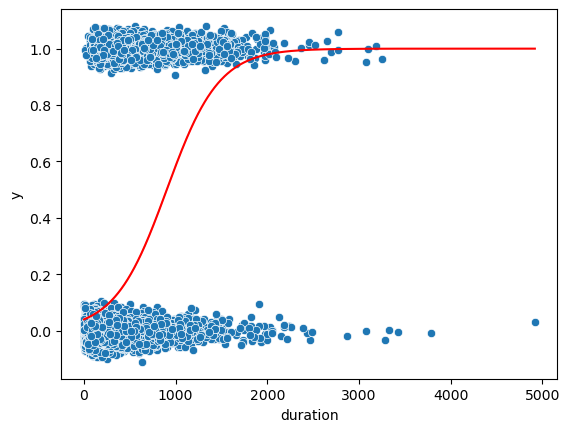

In [27]:
sns.scatterplot(x=train.duration, y=train.y + np.random.normal(loc=0.0, scale = 0.025, size=train.y.shape), data=train)
sns.lineplot( x=train.duration, y=trained_model.predict(train),data=train, color = 'red')

### j)

Using a decision threshold of 0.5, find and print the accuracy and recall scores for both test datasets (4 scores in total). **(2 points)** For each test dataset, you should see a big difference between the accuracy and recall scores. Explain why this is happening and which metric is a more realistic evaluation of the prediction performance. **(3 points)**

**Note:** Your explanation should include the value counts of both classes. You may consider printing the value counts as well.

In [29]:
thr = 0.5

y1_pred = trained_model.predict(test1) > thr
y2_pred = trained_model.predict(test2) > thr

y1_pred_probs = trained_model.predict(test1)
y2_pred_probs = trained_model.predict(test2)

print(f'Test1 - Accuracy = {accuracy_score(test1.y,y1_pred)}, Recall = {recall_score(test1.y, y1_pred)}')
print(f'Test2 - Accuracy = {accuracy_score(test2.y,y2_pred)}, Recall = {recall_score(test2.y, y2_pred)}')

print(test1.y.value_counts())
print(test2.y.value_counts())

Test1 - Accuracy = 0.8886274509803922, Recall = 0.14864864864864866
Test2 - Accuracy = 0.8886714928585404, Recall = 0.16526138279932545
y
0    4508
1     592
Name: count, dtype: int64
y
0    4518
1     593
Name: count, dtype: int64


For both test datasets, we see a much higher accuracy score than recall score, around .9 and 0.15, respectively. Recall measures the ratio of correct class 1 predictions to all true class 1 observations -- a low score such as the ones we see here means that many class 1 observations are predicted as false negatives by the model, indicating 'conservativeness' in the model. However, our threshold is not very high, i.e. our model is not highly conservative. As shown in the value counts of both test datasets, there are about 9 times as many class 0 observations as there are class 1 observations, which makes accuracy a more realistic evaluation metric, since it considers the amount of correctly classified class 0 predictions as well.

### k)

Repeat Part j with a decision threshold of 0.3. Did the accuracy change much? How about recall? Explain why the results changed (or not) in terms of the confusion matrix elements (TPs, TNs, FPs and FNs). 

**(5 points: 1 point for the calculation, 2 points for the recall explanation, 2 points for the accuracy explanation)**

In [32]:
thr = 0.3

y1_pred = trained_model.predict(test1) > thr
y2_pred = trained_model.predict(test2) > thr

y1_pred_probs = trained_model.predict(test1)
y2_pred_probs = trained_model.predict(test2)

print(f'Test1 - Accuracy = {accuracy_score(test1.y,y1_pred)}, Recall = {recall_score(test1.y, y1_pred)}')
print(f'Test2 - Accuracy = {accuracy_score(test2.y,y2_pred)}, Recall = {recall_score(test2.y, y2_pred)}')

Test1 - Accuracy = 0.8841176470588236, Recall = 0.30067567567567566
Test2 - Accuracy = 0.8863236157307768, Recall = 0.2951096121416526


Accuracy stayed about the same, around 0.9, and recall increased to about 0.3 for both test datasets. Since our threshold is lower, the model is more likely to predict an observation as being class 1, so the ratio of true positives to total class 1 observations, true positives + false negatives, increased accordingly. Accuracy stayed about the same -- while the model correctly predicts more class 1 observations, it misses more true negatives, so the true negative count decreases. Since accuracy is the percentage of correctly predicted observations of total observations and of the terms in the numerator, TP and TN, one increased and one decreased, this explains why there was not a drastic change in accuracy.

## 2) Exploring Variable Interactions (9 points)

### a)

Using the training data and the **statsmodels** library, create and train a logistic regression model that predicts whether the client subscribed to a term deposit or not by using their `education` level and their `age`. 

**Assume that the effect of age on the probability of client subscription **depends on** the education level of the client.** Print the model summary. **(2 points)**

You will use this model to answer all the remaining parts of this question.

In [36]:
model = smf.logit('y~education*age', data=train).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.356771
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                35000
Model:                          Logit   Df Residuals:                    34992
Method:                           MLE   Df Model:                            7
Date:                Mon, 17 Feb 2025   Pseudo R-squ.:                 0.01288
Time:                        22:06:10   Log-Likelihood:                -12487.
converged:                       True   LL-Null:                       -12650.
Covariance Type:            nonrobust   LLR p-value:                 1.897e-66
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -4.6063      0.209    -22.083      0.000      -5.015      -4.197
education[T.secondary]         2.1168      0.231      9.180      0.000       1.665       2.569
education[T.tertiary]          2.8103      0.238     11.832      0.000       2.345       3.276
education[T.unknown]           2.6776      0.359      7.455      0.000       1.974       3.382
age                            0.0462      0.004     11.636      0.000       0.038       0.054
education[T.secondary]:age    -0.0371      0.005     -8.063      0.000      -0.046      -0.028
education[T.tertiary]:age     -0.0447      0.005     -9.230      0.000      -0.054      -0.035
education[T.unknown]:age      -0.0443      0.007     -5.957      0.000      -0.059      -0.030
==============================================================================================
"""

### b)

Which education level has the highest percentage increase in odds of the client subscribing with a unit increase in their age? Justify your answer by comparing the percentage increases for all education levels in the data. **(3 points)**

In [38]:
#print(train.education.value_counts())

print(f'Secondary: {np.exp(model.params['age'] + model.params['education[T.secondary]:age']) -1}')
print(f' Tertiary: {np.exp(model.params['age'] + model.params['education[T.tertiary]:age']) -1}')
print(f' Primary: {np.exp(model.params['age']) -1}') # primary
print(f' Unknown: {np.exp(model.params['age'] + model.params['education[T.unknown]:age']) -1}')

Secondary: 0.009058022202870664
 Tertiary: 0.0014824258262073897
 Primary: 0.04723644883804101
 Unknown: 0.001830309809183417


Primary education level has the highest increase in odds of client subscription per unit increase in age - about 5%.

### c)

What is the maximum age of a client with `tertiary` education that has a predicted subscription probability of 15% or lower? **(4 points)**

In [41]:
train.loc[model.predict(train) < .15, 'age'].max()

#prob = model.params['Intercept'] + model.params['education[T.tertiary]'] + age*(model.params['age'] + model.params['education[T.tertiary]:age'])
(np.log(0.15/0.85) - (model.params['Intercept'] + model.params['education[T.tertiary]'])) / (model.params['age'] + model.params['education[T.tertiary]:age'])

41.415846877002714

## 3) Model Development and Evaluation (26 points)

### a)

Using the training data and the **statsmodels** library, create and train a logistic regression model that predicts whether the client subscribed to a term deposit or not. The predictors are `age`, `education`, `day` and `month`. The model is required to have:

- A minimum of 75.0% accuracy for all three datasets (training and two test datasets). **(4 points)**
- A minimum of 50.0% recall for all three datasets. **(4 points)**

Print the model summary. **(1 point)** For all three datasets, print the accuracy scores, recall scores and confusion matrices. **(2 points)**

**Notes:**

1) **You cannot use `duration` as a predictor.** (The reason is explained in Introduction.) **Any solution that uses duration as part of the model will not receive any credit for the entire question.**
2) You may need to explore some interactions and transformations.
3) You are free to choose the decision threshold as you wish. **However, you are required to use the same threshold for all three datasets for credit.**
4) Your scores need to meet the minimum requirements without any rounding off. (For example, a recall of 49.9% is not considered correct.)

You will use this model (and threshold, unless stated otherwise) to answer all the remaining parts of this question.

In [44]:
model = smf.logit('y~age*education + day*month + I(age**2)', data=train).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.322666
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                35000
Model:                          Logit   Df Residuals:                    34968
Method:                           MLE   Df Model:                           31
Date:                Mon, 17 Feb 2025   Pseudo R-squ.:                  0.1072
Time:                        22:06:11   Log-Likelihood:                -11293.
converged:                       True   LL-Null:                       -12650.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.1446      0.347      0.417      0.677      -0.536       0.825
education[T.secondary]         0.0492      0.217      0.227      0.821      -0.376       0.474
education[T.tertiary]          0.5063      0.225      2.254      0.024       0.066       0.947
education[T.unknown]           0.9275      0.327      2.833      0.005       0.286       1.569
month[T.aug]                   1.1418      0.185      6.159      0.000       0.778       1.505
month[T.dec]                   2.2415      0.340      6.601      0.000       1.576       2.907
month[T.feb]                  -0.1687      0.187     -0.904      0.366      -0.534       0.197
month[T.jan]                   4.4757      0.442     10.130      0.000       3.610       5.342
month[T.jul]                   0.5553      0.190      2.929      0.003       0.184       0.927
month[T.jun]                   0.4512      0.181      2.491      0.013       0.096       0.806
month[T.mar]                   2.5508      0.250     10.217      0.000       2.061       3.040
month[T.may]                  -0.1391      0.180     -0.774      0.439      -0.492       0.213
month[T.nov]                   2.6127      0.277      9.430      0.000       2.070       3.156
month[T.oct]                   0.9884      0.274      3.612      0.000       0.452       1.525
month[T.sep]                   1.8823      0.235      7.994      0.000       1.421       2.344
age                           -0.1386      0.011    -12.472      0.000      -0.160      -0.117
age:education[T.secondary]     0.0071      0.005      1.554      0.120      -0.002       0.016
age:education[T.tertiary]      0.0025      0.005      0.529      0.597      -0.007       0.012
age:education[T.unknown]      -0.0112      0.007     -1.626      0.104      -0.025       0.002
day                            0.0565      0.008      7.249      0.000       0.041       0.072
day:month[T.aug]              -0.1109      0.010    -11.160      0.000      -0.130      -0.091
day:month[T.dec]              -0.0631      0.020     -3.170      0.002      -0.102      -0.024
day:month[T.feb]               0.0631      0.012      5.223      0.000       0.039       0.087
day:month[T.jan]              -0.2228      0.018    -12.422      0.000      -0.258      -0.188
day:month[T.jul]              -0.0797      0.010     -8.359      0.000      -0.098      -0.061
day:month[T.jun]              -0.0701      0.010     -6.736      0.000      -0.090      -0.050
day:month[T.mar]              -0.0756      0.014     -5.475      0.000      -0.103      -0.049
day:month[T.may]              -0.0575      0.009     -6.194      0.000      -0.076      -0.039
day:month[T.nov]              -0.1938      0.015    -12.746      0.000      -0.224      -0.164
day:month[T.oct]              -0.0029      0.014     -0.212      0.832      -0.030       0.024
day:month[T.sep]              -0.0411      0.014     -2.876      0.004      -0.069      -0.013
I(age ** 2)

In [45]:
thr = 0.122

ytrain_pred = model.predict(train) > thr
y1_pred = model.predict(test1) > thr
y2_pred = model.predict(test2) > thr

ytrain_pred_probs = model.predict(train)
y1_pred_probs = model.predict(test1)
y2_pred_probs = model.predict(test2)

print(f'Accuracy and recall scores:')

print(f'Train - Accuracy = {accuracy_score(train.y, ytrain_pred)}, Recall = {recall_score(train.y, ytrain_pred)}')
print(f'Test1 - Accuracy = {accuracy_score(test1.y,y1_pred)}, Recall = {recall_score(test1.y, y1_pred)}')
print(f'Test2 - Accuracy = {accuracy_score(test2.y,y2_pred)}, Recall = {recall_score(test2.y, y2_pred)}')


print(f'Confusion matrices:')
print('Train')
print(confusion_matrix(train.y, ytrain_pred))
print('Test1')
cm1 = confusion_matrix(test1.y, y1_pred)
print(cm1)
print('Test2')
cm2 = confusion_matrix(test2.y, y2_pred)
print(cm2)

Accuracy and recall scores:
Train - Accuracy = 0.7709714285714285, Recall = 0.5319200779727096
Test1 - Accuracy = 0.7731372549019608, Recall = 0.5067567567567568
Test2 - Accuracy = 0.7720602621796127, Recall = 0.5581787521079258
Confusion matrices:
Train
[[24801  6095]
 [ 1921  2183]]
Test1
[[3643  865]
 [ 292  300]]
Test2
[[3615  903]
 [ 262  331]]


### b)

What is the probability that the model will return a larger probability output for a client who subscribes compared to a client who does not? **You need to justify your answer for credit.** **(3 points)**

In [47]:
print('AUC expresses the probability that the model returns a larger output for a class 1 observation than a class 0 observation.')

fpr, tpr, thres = roc_curve(train.y, ytrain_pred_probs)
auc(fpr, tpr)*100

AUC expresses the probability that the model returns a larger output for a class 1 observation than a class 0 observation.


71.51520612634425

### c)

Project all your prediction results for both **test** datasets to real-life profits. Assume that:

- Only the clients who are predicted to subscribe are called.
- A client who is called and subscribes returns a profit of \$100.
- A client who is called and does not subscribe returns a loss of \$10.

What is the net profit of the test results? You need to return one final number. **(3 points)** Note that the confusion matrices printed in Part a can be helpful.

In [49]:
# FP = cm[0,1], TP = cm[1,1], FN = cm[1,0], TN = cm[1,1]

100*(cm1[1,1] + cm2[1,1]) - 10*(cm1[0,1] + cm2[0,1])

45420

### d)

Using the same assumptions in Part c, find the threshold that would maximize the net profit. You need to use the training data this time.

This can be the most challenging part of this assignment. Here are some suggestions:

- You do not need to calculate the results for every possible threshold. You should already have some metrics calculated for a large array of thresholds in Part b.
- Use those metrics and the proportion of Class 1 observations in the training dataset to find the net profit for all thresholds.
- Find the index of the highest profit and use it to find the best threshold. You should also have a threshold array from Part b.

**(5 points)**

In [119]:
# true pos and true neg
total_pos = sum(train.y)
total_neg = len(train.y) - total_pos

fpr, tpr, thres = roc_curve(train.y, ytrain_pred_probs)

profits = (100*tpr*total_pos/len(train.y)) - (10*fpr*total_neg/len(train.y))
max_idx = np.argmax(profits)
max_thres = thres[max_idx]
print(max_thres)

max_idx
x = fpr[max_idx]
y = tpr[max_idx]

len(profits)
#len(train.y)
#len(fpr)

total_pos + total_neg

print(len(fpr), len(tpr), len(thres))

print(f"Total Positives: {total_pos}, Total Negatives: {total_neg}")
print(f"FPR shape: {fpr.shape}, TPR shape: {tpr.shape}, Thresholds shape: {thres.shape}")
print(f"First 5 profits: {profits[:30]}")

0.10084795861336832
9984 9984 9984
Total Positives: 4104, Total Negatives: 30896
FPR shape: (9984,), TPR shape: (9984,), Thresholds shape: (9984,)
First 5 profits: [ 0.         -0.00028571  0.00257143  0.00228571  0.01371429  0.01342857
  0.022       0.02142857  0.03        0.02885714  0.03171429  0.03114286
  0.03971429  0.03942857  0.04228571  0.042       0.04485714  0.04428571
  0.05        0.04857143  0.05142857  0.05085714  0.068       0.07057143
  0.06971429  0.07542857  0.07514286  0.078       0.07742857  0.08028571]


### e)

Using the new threshold you found in Part d, calculate the net profit for the test datasets. You should see a better profit. Note that you need to reprint some test results for this. **(4 points)**

In [86]:
thr = max_thres


y1_pred = model.predict(test1) > thr
y2_pred = model.predict(test2) > thr


cm1 = confusion_matrix(test1.y, y1_pred)
cm2 = confusion_matrix(test2.y, y2_pred)


100*(cm1[1,1] + cm2[1,1]) - 10*(cm1[0,1] + cm2[0,1])

49380

## 4) Data Visualization with Classification Results (6 points)

### a)

Plot the Receiver Operating Characteristics (ROC) curve for the model you trained in Question 3. Mark the point that corresponds to the decision threshold you found in Part 3d. (You can use a red solid point or any shape/color you want, as long as it is clearly marked.) Make sure you have the axis labels and the x=y line for comparison. **(2 points)**

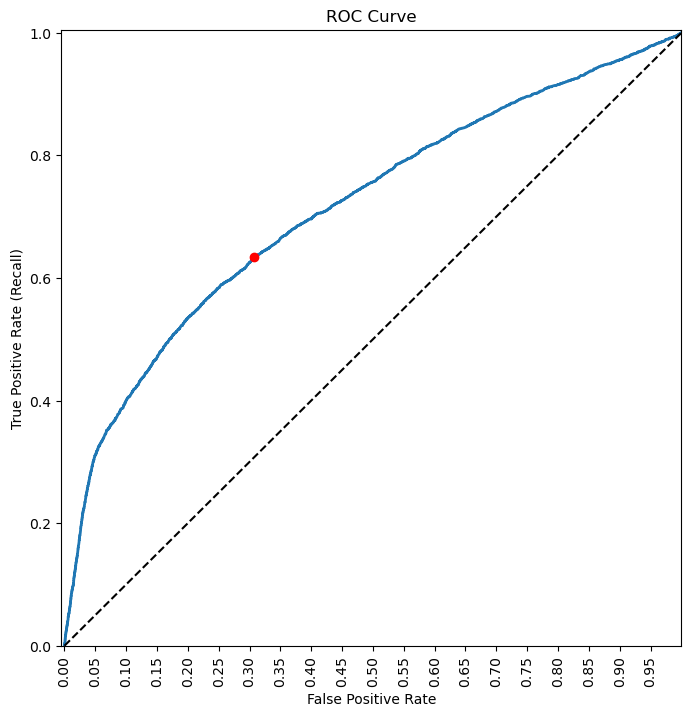

In [90]:
# x,y for profit maximizing threshold calculated in 3d


plt.figure(figsize=(8,8))
plt.title('ROC Curve')
plt.plot(fpr, tpr, linewidth=2) # creates ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0,1, 0.05), rotation=90)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")        # pasted from 4.6.2 in python repo
plt.plot(x,y,'o',color='red', label = "Decision threshold probability")
plt.show()

### b)

Convert the previous plot to a scatter plot of TPR (Recall) against FPR and color-code each point based on the corresponding profit. Add a `colorbar` to the plot. **(2 points)**

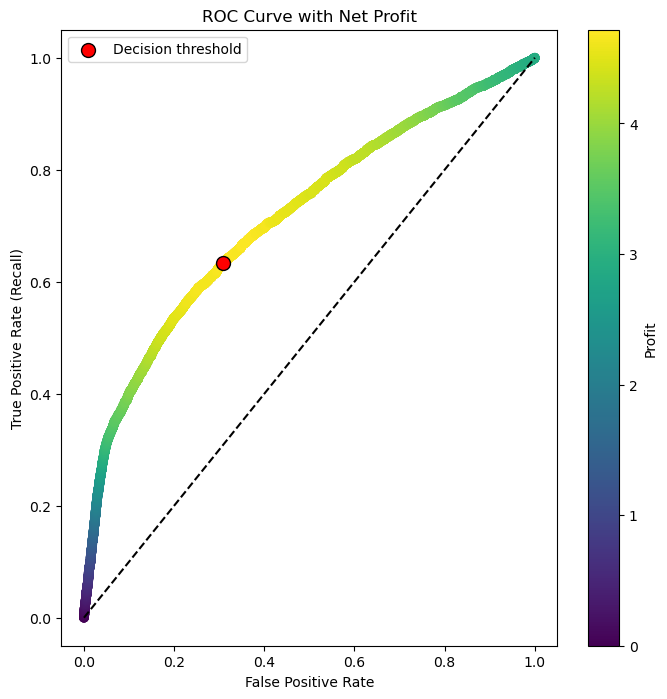

In [147]:


fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(fpr, tpr, c=profits, cmap='viridis')
cbar = plt.colorbar(scatter)
cbar.set_label("Profit")
ax.plot([0, 1], [0, 1], 'k--')
ax.scatter(x, y, color='red', s=100, edgecolors='black', label="Decision threshold")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate (Recall)")
plt.title('ROC Curve with Net Profit')
ax.legend()
plt.show()



### c)

Plot the Precision-Recall (PR) curve for the model you trained in Question 3. Mark the decision threshold you found in Part 3d as **a dashed vertical line**. Make sure you have the axis labels and a legend. **(2 points)**

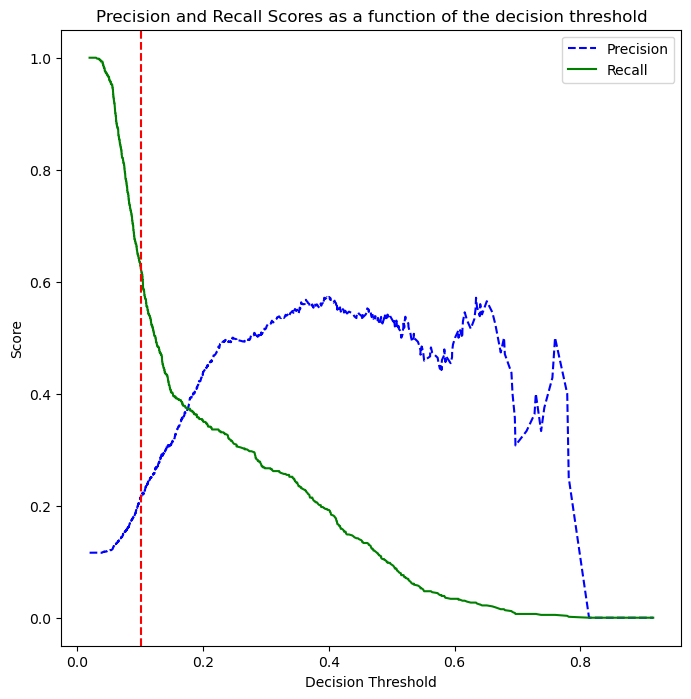

In [150]:
p, r, thresholds = precision_recall_curve(test1.y, y1_pred_probs)

# max_thres calculated in 3d

plt.figure(figsize=(8, 8))
plt.title("Precision and Recall Scores as a function of the decision threshold")
plt.plot(thresholds, p[:-1], "b--", label="Precision")
plt.plot(thresholds, r[:-1], "g-", label="Recall")
plt.ylabel("Score")
plt.xlabel("Decision Threshold")
plt.legend(loc='best')
plt.legend()
plt.axvline(max_thres, color='red', linestyle='--')

## 5) Preprocessing and Prediction with scikit-learn (13 points)

For this question, you will use the training and the **first** test dataset (from **train.csv** and **test1.csv**). **You are only allowed to use scikit-learn, pandas and numpy** to preprocess the data and train a non-linear logistic regression model. You need the following steps:

- The classification response is `y`. **(1 point)**
- The predictors are `education`, `month`, `day` and `age`. Note that two of them are numeric and two of them are categorical. **(1 point)**
- Transform the numerical predictors to **all** their second-order polynomial versions (including the interaction). **(3 points)** You are required to use a scikit-learn object for credit; creating all polynomial terms manually is not accepted.
- One-hot-encode the categorical predictors. Drop the dummy variable of the baseline category. **(2 points)** You are required to use only an extra input for this; dropping the variable manually is not accepted.
- Concatenate the processed numeric and categorical predictors back together. **(1 point)**
- Standard scale the predictors. **(2 points)**

Note that both training and test data needs to go through the **exact** same sequence of transformations. You need to be careful about this especially while scaling.

Using the preprocessed datasets, create, train and evaluate a Logistic Regression model. Print the accuracy and recall for both the training and the test data with a decision threshold of 0.11. **(3 points)**

In [154]:
# model

model = LogisticRegression(penalty=None)

# slice predictors and response vars

x_train_num = train[['day','age']]
x_train_cat = train[['education', 'month']]
y_train = train['y']

x_test_num = test1[['day','age']]
x_test_cat = test1[['education', 'month']]
y_test = test1['y']

# transformations

poly = PolynomialFeatures(2, include_bias = False)

x_train_poly = poly.fit_transform(x_train_num)
x_train_ohe = pd.get_dummies(x_train_cat, drop_first=True)

x_test_poly = poly.fit_transform(x_test_num)
x_test_ohe = pd.get_dummies(x_test_cat, drop_first=True)

x_train_new = np.concatenate([x_train_poly, x_train_ohe], axis=1)
x_test_new = np.concatenate([x_test_poly, x_test_ohe], axis=1)

# scaling

scaler = StandardScaler()
scaler.fit(x_train_new)
x_train_scaled = scaler.transform(x_train_new)
x_test_scaled = scaler.transform(x_test_new)

# model predictions + scores

model.fit(x_train_scaled, y_train)
thr = 0.11


y_train_pred = (model.predict_proba(x_train_scaled)[:,1] > thr)
y_test_pred = (model.predict_proba(x_test_scaled)[:,1] > thr)


print('Train accuracy:', accuracy_score(y_train, y_train_pred))
print('Test accuracy:', accuracy_score(y_test,y_test_pred))

print('Train recall:', recall_score(y_train, y_train_pred))
print('Test recall:', recall_score(y_test, y_test_pred))

Train accuracy: 0.6842
Test accuracy: 0.6911764705882353
Train recall: 0.5891812865497076
Test recall: 0.5929054054054054
